# Video Games Review: Analysis

In this project, I explore [Metacritic's video games reviews](https://www.metacritic.com/browse/games/score/metascore/all/all/filtered?page=0).


## Setup

In this section, I import all necessary libraries, setup the SQLite database, and then import the input `.csv` files in a format that allows manipulation by both `sqlite` and `pandas`:


In [2]:
import pandas as pd
from sqlalchemy import create_engine

sql_engine = create_engine("sqlite://", echo=False)
games_df = pd.read_csv("./input/games.csv")


In [3]:
def df_to_sql_table(sql_table_name: str, dataframe: pd.DataFrame) -> None:
    dataframe.to_sql(sql_table_name, sql_engine, if_exists="replace", index=False)
    print(
        f"""SQL table "{sql_table_name}" created/updated!

Please see below for a preview:"""
    )
    preview_sql_table(sql_table_name, sql_engine_name=sql_engine)


def preview_sql_table(
    sql_table_name: str,
    sql_engine_name,
    row_count=3,
) -> None:
    preview_sql_query = f"""SELECT * FROM {sql_table_name} LIMIT {row_count}"""
    display(pd.read_sql_query(preview_sql_query, sql_engine_name))


df_to_sql_table("games", games_df)


SQL table "games" created/updated!

Please see below for a preview:


,name,platform,release_date,summary,metascore,userscore
0,! SPACE ACCIDENT !,PC,"February 10, 2022",The year is 2119. A turning point has begun in...,tbd,tbd
1,! That Bastard Is Trying To Steal Our Gold !,PC,"May 11, 2014",It's a fun puzzle game where you need to steal...,tbd,3.4
2,!4RC4N01D!,PC,"January 12, 2018",Hardcore arkanoid in the spirit of old games f...,tbd,4.0


## Cleaning


### Missing Values


#### `tbd` Metascore and user score are missing values

Metascore will be `tbd` if there are <4 reviews for that game. User score will be "tbd" if there are <7 reviews for that game.


In [4]:
import numpy as np

score_columns = [sc for sc in games_df.columns if sc.endswith("score")]
for c in score_columns:
    games_df[c] = games_df[c].replace("tbd", np.NaN)

df_to_sql_table("games", games_df)


SQL table "games" created/updated!

Please see below for a preview:


,name,platform,release_date,summary,metascore,userscore
0,! SPACE ACCIDENT !,PC,"February 10, 2022",The year is 2119. A turning point has begun in...,None,None
1,! That Bastard Is Trying To Steal Our Gold !,PC,"May 11, 2014",It's a fun puzzle game where you need to steal...,None,3.4
2,!4RC4N01D!,PC,"January 12, 2018",Hardcore arkanoid in the spirit of old games f...,None,4.0


#### `summary`, `metascore` and `userscore` are difficult to impute

They are ignored for now, and will not be considered in analyses.


In [5]:
def count_missing_values(sql_table_name: str, col: str):
    count_missing_values_query = f"""
        SELECT SUM(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) missing_values_count
        FROM {sql_table_name}
    """

    missing_count_df = pd.read_sql_query(count_missing_values_query, sql_engine)
    number_of_missing_values = int(missing_count_df.missing_values_count.iloc[0])
    print(f"""The column "{col}" has _{number_of_missing_values}_ missing values.""")
    if number_of_missing_values:
        show_missing_values_query = f"""
            SELECT *
            FROM {sql_table_name}
            WHERE {col} IS NULL
        """
        missing_values_df = pd.read_sql_query(show_missing_values_query, sql_engine)
        display(missing_values_df)
        return
    return


for c in games_df.columns:
    count_missing_values("games", c)


The column "name" has _0_ missing values.
The column "platform" has _0_ missing values.
The column "release_date" has _0_ missing values.
The column "summary" has _17715_ missing values.


,name,platform,release_date,summary,metascore,userscore
0,100 Great Education Games Volume 4,PC,"May 10, 2002",None,None,None
1,1001 Jigsaw Cute Cats,PC,"August 3, 2022",None,None,None
2,1010! World,iOS,"July 6, 2015",None,None,None
3,18 Wheels of Steel: Hard Truck,PC,"March 18, 2021",None,None,None
4,1912 Titanic Mystery,PC,"July 17, 2019",None,None,5.3
...,...,...,...,...,...,...
17710,without Kungfu shut up,PC,"November 29, 2018",None,None,None
17711,work girl,PC,"November 22, 2019",None,None,None
17712,world of cubes,PC,"June 27, 2022",None,None,None
17713,xdding,PC,"December 23, 2022",None,None,None


The column "metascore" has _112155_ missing values.


,name,platform,release_date,summary,metascore,userscore
0,! SPACE ACCIDENT !,PC,"February 10, 2022",The year is 2119. A turning point has begun in...,None,None
1,! That Bastard Is Trying To Steal Our Gold !,PC,"May 11, 2014",It's a fun puzzle game where you need to steal...,None,3.4
2,!4RC4N01D!,PC,"January 12, 2018",Hardcore arkanoid in the spirit of old games f...,None,4.0
3,!4RC4N01D! 2: Retro Edition,PC,"February 6, 2018","Everyone dreams of returning 2007, but no one ...",None,3.8
4,!4RC4N01D! 3: Cold Space,PC,"March 8, 2018",!4RC4N01D! returns! This time we have an accid...,None,3.0
...,...,...,...,...,...,...
112150,{Undefined},PC,"August 20, 2021","A sandbox survival game, set on life-sized vox...",None,None
112151,~ Daydream ~,PC,"May 26, 2022",~Daydream~is an action 2D platform jumping gam...,None,None
112152,~Azur Ring~virgin and slave's phylacteries,PC,"July 17, 2020",New DIABLO-Like adventure game. Legendary gear...,None,None
112153,~Gigantify~,PC,"January 23, 2022",This is a small Puzzle Platformer where you dy...,None,None


The column "userscore" has _105986_ missing values.


,name,platform,release_date,summary,metascore,userscore
0,! SPACE ACCIDENT !,PC,"February 10, 2022",The year is 2119. A turning point has begun in...,None,None
1,!Arre Unicornio!,PC,"March 18, 2022",Arre Unicornio! is an online multiplayer video...,None,None
2,"""Aha! I Found It!"" Hidden Object Game",Wii,"January 25, 2010",[WiiWare] A hidden-object game for everyone h...,None,None
3,"""Aha! I Got It!"" Escape Game",Wii,"November 2, 2009",[WiiWare] Play alone or with family and frien...,None,None
4,"""Burn your fat with me!!""",iOS,"September 25, 2012",“Burn your fat with me!!” is a fitness app/dat...,None,None
...,...,...,...,...,...,...
105981,{Undefined},PC,"August 20, 2021","A sandbox survival game, set on life-sized vox...",None,None
105982,~ Daydream ~,PC,"May 26, 2022",~Daydream~is an action 2D platform jumping gam...,None,None
105983,~Azur Ring~virgin and slave's phylacteries,PC,"July 17, 2020",New DIABLO-Like adventure game. Legendary gear...,None,None
105984,~Gigantify~,PC,"January 23, 2022",This is a small Puzzle Platformer where you dy...,None,None


### Correct Data Types


In [6]:
for c in score_columns:
    games_df[c] = pd.to_numeric(games_df[c])

games_df["release_date"] = pd.to_datetime(games_df["release_date"], format="%B %d, %Y")
games_df["release_date"] = games_df["release_date"].dt.strftime("%Y-%m-%d")

df_to_sql_table("games", games_df)


SQL table "games" created/updated!

Please see below for a preview:


,name,platform,release_date,summary,metascore,userscore
0,! SPACE ACCIDENT !,PC,2022-02-10,The year is 2119. A turning point has begun in...,None,NaN
1,! That Bastard Is Trying To Steal Our Gold !,PC,2014-05-11,It's a fun puzzle game where you need to steal...,None,3.4
2,!4RC4N01D!,PC,2018-01-12,Hardcore arkanoid in the spirit of old games f...,None,4.0


## Analysis


### Metascore vs User Scores

There are up to two scores (assuming sufficient rating volumes) for each game:

- A game's **Metascore** is the [weighted average of critics' and publications' reviews](https://www.metacritic.com/about-metascores).
- A game's **user score** is the mean of users' scores.


#### Metascores and user scores have a **_low_**, **_positive_** correlation

The Pearson Correlation Coefficient is approx `+0.270`.

Unlike other SQL implementations (like PostgreSQL's `CORR()`), SQLite lacks built-in function to calculate the correlation coefficient. Thus, I implement the calculation manually using the formula:

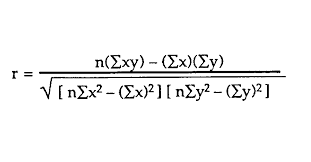


In [7]:
pd.read_sql_query(
    """
    SELECT AVG( (userscore - avg_userscore) * (metascore - avg_metascore) ) * AVG( (userscore - avg_userscore) * (metascore - avg_metascore) ) / (var_userscore * var_metascore) AS pearson_corr_coeff 
    FROM games,
        (
            SELECT avg_userscore,
                avg_metascore,
                AVG((userscore - avg_userscore)*(userscore - avg_userscore)) as var_userscore,
                AVG((metascore - avg_metascore)*(metascore - avg_metascore)) as var_metascore
            FROM games,
                (
                    SELECT AVG(userscore) AS avg_userscore,
                        AVG(metascore) AS avg_metascore
                    FROM games
                )
        )
    """,
    sql_engine,
)


,pearson_corr_coeff
0,0.215795


Visually, a scatterplot of all games' user score (x-axis) against Metascore (y-axis) validates this positive correlation.


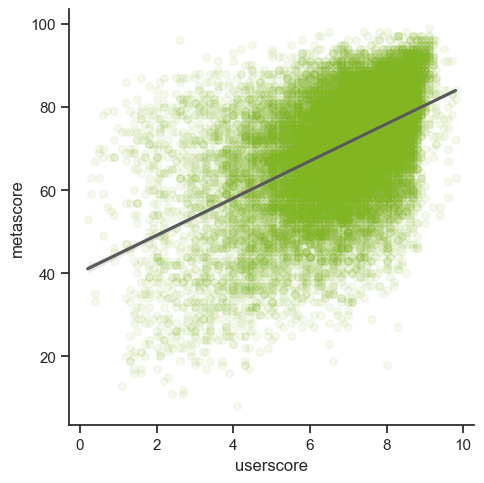

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
sns.lmplot(
    data=games_df,
    x="userscore",
    y="metascore",
    scatter_kws={"color": "#81B622", "alpha": 0.08, "s": 30},
    line_kws={"color": "#595959"},
)
plt.show()


### Platforms


#### Which platform has the "best" games is different based on Metacritics' and users' reviews


_NB: as SQLite does not have a built-in function nor efficient alternative to query the median values of each platform, we use `pandas`' `.median()` method:_


In [49]:
def find_median_scores(input_sql_table: str) -> pd.DataFrame:
    scores_stacked_by_type_df = melt_table_by_score_type("games")
    res_df = (
        scores_stacked_by_type_df.groupby(["platform", "score_type"])
        .score.median()
        .reset_index()
        .rename(columns={"score": "median_score"})
    )
    return res_df


def melt_table_by_score_type(input_table: str) -> pd.DataFrame:
    melt_sql_query = f"""
        SELECT name,
            platform,
            metascore / 10 score, 
            'meta' score_type,
            STRFTIME('%Y-%m-%d', release_date) release_date
        FROM {input_table}
        WHERE score NOT NULL
        UNION ALL
        SELECT name,
            platform,
            userscore score,
            'user' score_type,
            STRFTIME('%Y-%m-%d', release_date) release_date
        FROM {input_table}
        WHERE score NOT NULL
    """
    res_df = pd.read_sql_query(melt_sql_query, sql_engine)
    return res_df


median_scores = find_median_scores("games")
median_scores.sort_values("median_score", ascending=False)


,platform,score_type,median_score
5,Dreamcast,user,8.00
19,PlayStation 2,user,7.90
11,Nintendo 64,user,7.85
7,Game Boy Advance,user,7.80
9,GameCube,user,7.80
10,Nintendo 64,meta,7.80
17,PlayStation,user,7.80
44,iOS,meta,7.60
42,Xbox Series X,meta,7.60
37,Xbox,user,7.50


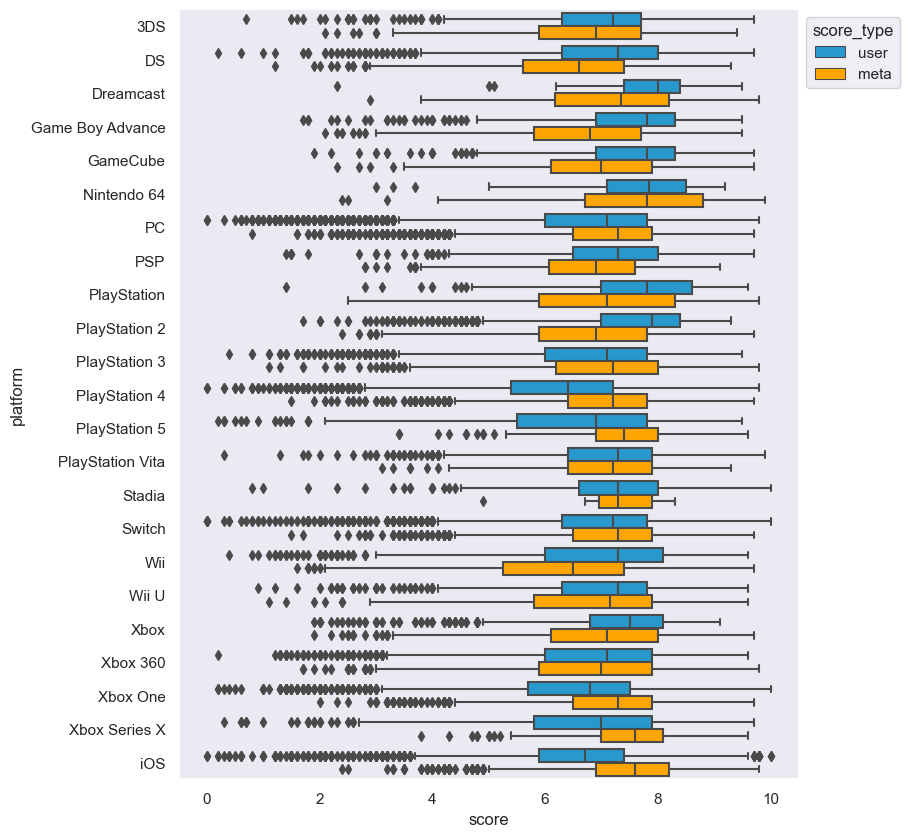

In [51]:
def boxplot_game_reviews(
    score_type_filter=["user", "meta"],
    platform_filter=False,
):
    sns.set(style="dark")
    scores_stacked_df = melt_table_by_score_type("games")
    data_df = scores_stacked_df[scores_stacked_df.score_type.isin(score_type_filter)]
    if platform_filter:
        data_df = data_df[data_df.platform.isin(platform_filter)]

    plt.figure(figsize=(8, 10))
    ax = sns.boxplot(
        data=data_df.sort_values("platform"),
        x="score",
        y="platform",
        hue="score_type",
        orient="h",
        palette=["#2998cd", "orange"],
        saturation=1,
    )
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.show()


boxplot_game_reviews()


#### Overall, users agree that **_handheld_** games are better

- Across all platform types, Metascores vary far more between games than user scores.
- Overall, users tend to rate **_handheld_** games the highest, followed by "hybrid" games (which refers to the Nintendo Switch, which can be played both as a _handheld_ platform and a home console).
- _iOS_ games have the lowest median user scores, albeit only slightly compared to the other categories


In [17]:
platform_type_df = pd.read_sql_query(
    """
    SELECT *,
        CASE
            WHEN platform IN ('3DS', 'DS', 'Game Boy Advance', 'PSP', 'PlayStation Vita') THEN 'handheld'
            WHEN platform IS 'Switch' THEN 'hybrid'
            WHEN platform IS 'PC' THEN 'pc'
            WHEN platform IS 'iOS' THEN 'mobile'
            ELSE 'home console'
        END platform_type
    FROM games
    """,
    sql_engine,
)
platform_type_df.head(3)


,name,platform,release_date,summary,metascore,userscore,platform_type
0,! SPACE ACCIDENT !,PC,2022-02-10,The year is 2119. A turning point has begun in...,NaN,NaN,pc
1,! That Bastard Is Trying To Steal Our Gold !,PC,2014-05-11,It's a fun puzzle game where you need to steal...,NaN,3.4,pc
2,!4RC4N01D!,PC,2018-01-12,Hardcore arkanoid in the spirit of old games f...,NaN,4.0,pc


In [ ]:
df_to_sql_table("scores_unpivoted", scores_stacked_df)


In [ ]:
# transforming table in preparation for split boxplot
scores_unpivoted_platform_cats = pd.read_sql_query(
    """
    SELECT *,
        CASE
            WHEN platform IN ('3DS', 'DS', 'Game Boy Advance', 'PSP', 'PlayStation Vita') THEN 'handheld'
            WHEN platform IS 'Switch' THEN 'hybrid'
            WHEN platform IS 'PC' THEN 'pc'
            WHEN platform IS 'iOS' THEN 'mobile'
            ELSE 'home console'
        END platform_type
    FROM scores_unpivoted
    """,
    sql_engine,
)

plt.figure(figsize=(10, 8))
sns.violinplot(
    data=scores_unpivoted_platform_cats,
    x="platform_type",
    y="score",
    hue="score_type",
    palette=["orange", "#2998cd"],
    split=True,
)
plt.show()


### Games released in the **_late 90s_** tend to have higher user scores and Metascores...

-- NEED TO CHANGE --

Which aligns with our findings above that N64 (released 1996) and PS1 (released 1994) had the highest rated games

- As time goes by, newer-released games tend to attract _lower_ user scores (although there are exceptions, in the form of outliers)
- Games released in 2006-2008 inclusive attracted poorer Metascores


In [ ]:
scores_stacked_df["release_date"] = pd.to_datetime(
    scores_stacked_df.release_date, format="%Y-%m-%d"
)

plt.figure(figsize=(25, 8))
sns.violinplot(
    data=scores_stacked_df,
    x=scores_stacked_df.release_date.dt.year,
    y="score",
    hue="score_type",
    split=True,
    palette=["orange", "#2998cd"],
)
plt.xticks(rotation=90)
plt.show()


Median scores (which are less sensitive to outliers compared to mean) confirm these findings:

1. Median user scores decline as the game is released more recently, reaching a historical low for games released in 2023
2. Median Metascores have stayed around `7.0` following a dip for games released 2006-2008 inclusive.


In [ ]:
scores_stacked_by_year = scores_stacked_df.copy().drop("platform", axis=1)
scores_stacked_by_year["release_date"] = pd.to_datetime(
    scores_stacked_by_year.release_date, format="%Y-%m-%d"
)
scores_stacked_by_year["release_year"] = scores_stacked_by_year.release_date.dt.year
median_scores_by_year = (
    scores_stacked_by_year.groupby(["release_year", "score_type"])
    .score.median()
    .reset_index()
    .rename(columns={"score": "median_score"})
)
# median_scores_by_year.head(5)

plt.figure(figsize=(10, 8))
sns.lineplot(
    data=median_scores_by_year,
    x="release_year",
    y="median_score",
    hue="score_type",
    palette=["#2998cd", "orange"],
    linewidth=3.5,
)
plt.show()


In [ ]:
scores_stacked_by_year


In [ ]:
games_df.sort_values("release_date", ascending=True)
